# Application of CNNs on MNIST dataset

## 1. Importing libraries

In [1]:
import matplotlib.pyplot as plt 
import math
import numpy as np
import random as rd

<u><b>Warning:</b></u> This notebook runs on tensorflow version 1.14 (tested using an installation of tensorflow-gpu v1.14.0)

In [2]:
import tensorflow as tf
tf.__version__

'1.14.0'

## 2. Importing datasets
The MNIST datasets are kindly provided by Yann Lecun on his [website](http://yann.lecun.com/exdb/mnist/).

They are directly accessibly through the tensorflow library as seen below.

In [3]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels),(test_images, test_labels) = mnist.load_data()

Image n°26315's label is 0.
The image is of shape (28, 28).


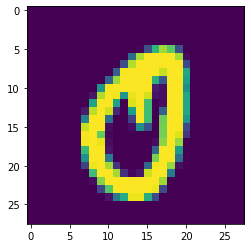

In [4]:
# Testing random image and its label from the training set.
random_image = rd.randrange(train_images.shape[0])
plt.imshow(train_images[random_image])
print(f"Image n°{random_image}'s label is {train_labels[random_image]}.")
print(f"The image is of shape {train_images[random_image].shape}.")

## 3. Data Preprocessing

<u>1. Declaring pre-processing functions:</u>

In [5]:
def convert_to_one_hot(array):
    """
    Converts a numpy array of shape (number_instances, 1) to one-hot encodings
    of shape (number_instances, number_labels)
    ---
    variable <array>: <class 'numpy.ndarray'>
    """    
    # Using np.reshape is necessary so the one-hot encodings are not a nested list.
    new_array = np.array(array).reshape(-1)
    return np.eye(np.max(array)+1)[new_array]

<u>2. Reshaping train and test image/label arrays:</u>

In [6]:
# Expanding by 1 the dimension of train and test images to indicate that MNIST data are 
#in greyscale, i.e. 1 channel
train_images = np.expand_dims(train_images,axis=3)
test_images = np.expand_dims(test_images,axis=3)

# Reshaping labels to indicate the dimension of the secondary axis
train_labels = np.reshape(train_labels,(train_labels.shape[0],1))
test_labels = np.reshape(test_labels,(test_labels.shape[0],1))

print("Dimensions of:",
      "- Training features array: " + str(train_images.shape), 
      "- Training labels array: " + str(train_labels.shape), 
      "- Testing features array: " + str(test_images.shape), 
      "- Testing labels array: " + str(test_labels.shape), 
      sep="\n")

Dimensions of:
- Training features array: (60000, 28, 28, 1)
- Training labels array: (60000, 1)
- Testing features array: (10000, 28, 28, 1)
- Testing labels array: (10000, 1)


<u>3. Normalizing features:</u>

In [7]:
# Normalizing features. 
norm_train_images = train_images.astype(np.float32)/np.max(train_images) #i.e. /255
norm_test_images = test_images/np.max(test_images) #i.e. /255

<u>4. Converting train and test labels arrays to one-hot encodings:</u>

In [8]:
encoded_train_labels = convert_to_one_hot(train_labels)
encoded_test_labels = convert_to_one_hot(test_labels)

In [9]:
print("Dimensions of:",
      "- Training labels one-hot encoded array:" + str(encoded_train_labels.shape),
      "- Test labels one-hot encoded array:" + str(encoded_test_labels.shape),
      "\nImage n°" + str(random_image) + "'s one-hot encoding is " + \
      str(encoded_train_labels[random_image]) + ".",
      sep="\n")

Dimensions of:
- Training labels one-hot encoded array:(60000, 10)
- Test labels one-hot encoded array:(10000, 10)

Image n°26315's one-hot encoding is [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.].


## 4. Laying out the CNN Model

<u>1. Declaring pre-processing functions:</u>

In [10]:
def tensorflow_placeholders(instance_height, 
                            instance_width, 
                            instance_channels, 
                            label_numbers):
    """
    Creates tensorflow placeholders for a tensorflow session.
    ---
    variables <class 'int'>: <instance_height>, <instance_width>, <instance_channel>, <label_numbers>
    """
    placeholder_data = tf.placeholder(tf.float32, shape=(None,
                                                         instance_height,
                                                         instance_width,
                                                         instance_channels))
    placeholder_labels = tf.placeholder(tf.float32, shape=(None, label_numbers))
    return placeholder_data, placeholder_labels

def initialize_parameters(variable_name, filter_shape):
    """
    Initializes weght parameters and returns returns a tensor with shape:
    [filter_height, filter_width, in_channels, out_channels].
    ---
    variable <class 'int'>: <filter_height>, <filter_width>, <channels_in>, <channels_out>
    variable <class 'lst'>: <filter_shape> (listing variables: <class 'int'>)
    variable <class 'str'>: <variable_name>
    """
    weights = tf.get_variable(variable_name, filter_shape, 
                              initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    return weights

<u>2. Setting up parameters and hyperparameters:</u>

In [11]:
# Creating the filter shapes
convolution_filter_shapes = ([1,1,1,64],
                             [5,5,64,32],
                             [5,5,32,16],
                             [3,3,16,8])

In [12]:
# Declaring the hyperparameters
strides = {"cnn_layer_1": [1,1,1,1], 
           "cnn_layer_2": [1,3,3,1], 
           "cnn_layer_3": [1,5,5,1], 
           "cnn_layer_4": [1,5,5,1], 
           "max_pool_layer_1": [1,1,1,1],
           "max_pool_layer_2": [1,3,3,1],
           "max_pool_layer_3": [1,5,5,1],
           "max_pool_layer_4": [1,5,5,1]}

kernel_size = {"max_pool_layer_1": [1,1,1,1], 
               "max_pool_layer_2": [1,3,3,1], 
               "max_pool_layer_3": [1,5,5,1], 
               "max_pool_layer_4": [1,5,5,1]}

padding = {"cnn_layer_1": "SAME", 
           "cnn_layer_2": "SAME", 
           "cnn_layer_3": "SAME", 
           "cnn_layer_4": "SAME", 
           "max_pool_layer_1": "SAME", 
           "max_pool_layer_2": "SAME", 
           "max_pool_layer_3": "SAME", 
           "max_pool_layer_4": "SAME"}

output_layer_size = len(np.unique(train_labels))

hyperparameters = {"strides": strides, 
                   "kernel_size": kernel_size, 
                   "padding": padding, 
                   "output_size": output_layer_size, 
                   "learning_rate": 0.01, 
                   "number_epochs": 200,
                   "minibatch_size": 512, 
                   "cost_printing": True,
                   "seed": 0}

<u>3. Setting up tensorflow session structure:</u>

In [13]:
def forward_propagation(data, parameters, hyperparameters):
    """
    Implements the forward propagation for the machine learning model.
    ---
    variable <class 'numpy.ndarray'>: data
    variable <class 'dict'>: parameters, hyperparameters
    """
    #############
    ###LAYER 1###
    # CONV2D
    Z1 = tf.nn.conv2d(data, 
                      parameters["W1"], 
                      strides = hyperparameters["strides"]["cnn_layer_1"], 
                      padding = hyperparameters["padding"]["cnn_layer_1"])
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL
    P1 = tf.nn.max_pool(A1, 
                        ksize = hyperparameters["kernel_size"]["max_pool_layer_1"], 
                        strides = hyperparameters["strides"]["max_pool_layer_1"], 
                        padding = hyperparameters["padding"]["max_pool_layer_1"])
    #############
    ###LAYER 2###
    # CONV2D
    Z2 = tf.nn.conv2d(P1, 
                      parameters["W2"], 
                      strides = hyperparameters["strides"]["cnn_layer_2"], 
                      padding = hyperparameters["padding"]["cnn_layer_2"])
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL
    P2 = tf.nn.max_pool(A2, 
                        ksize = hyperparameters["kernel_size"]["max_pool_layer_2"], 
                        strides = hyperparameters["strides"]["max_pool_layer_2"], 
                        padding = hyperparameters["padding"]["max_pool_layer_2"])
    #############
    ###LAYER 3###
    # CONV2D
    Z3 = tf.nn.conv2d(P2, 
                      parameters["W3"], 
                      strides = hyperparameters["strides"]["cnn_layer_3"], 
                      padding = hyperparameters["padding"]["cnn_layer_3"])
    # RELU
    A3 = tf.nn.relu(Z3)
    # MAXPOOL
    P3 = tf.nn.max_pool(A3, 
                        ksize = hyperparameters["kernel_size"]["max_pool_layer_3"], 
                        strides = hyperparameters["strides"]["max_pool_layer_3"], 
                        padding = hyperparameters["padding"]["max_pool_layer_3"])
    #############
    ###LAYER 4###
    # CONV2D
    Z4 = tf.nn.conv2d(P3, 
                      parameters["W4"], 
                      strides = hyperparameters["strides"]["cnn_layer_4"], 
                      padding = hyperparameters["padding"]["cnn_layer_4"])
    # RELU
    A4 = tf.nn.relu(Z4)
    # MAXPOOL
    P4 = tf.nn.max_pool(A4, 
                        ksize = kernel_size["max_pool_layer_4"], 
                        strides = hyperparameters["strides"]["max_pool_layer_4"], 
                        padding = hyperparameters["padding"]["max_pool_layer_4"])
    #############
    ###LAYER 5###
    # FLATTEN
    F = tf.contrib.layers.flatten(P4)
    # FULLY-CONNECTED
    Z5 = tf.contrib.layers.fully_connected(F, 
                                           hyperparameters["output_size"], 
                                           activation_fn = None)
    return Z5

def cost(data, labels):
    """
    Computes the cost of the model.
    ---
    variables <class 'numpy.ndarray'>: data, labels
    """
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = data, 
                                                                  labels = labels))
    return cost

In [14]:
# Seeding random numbers for tensor parameters
tf.set_random_seed(hyperparameters["seed"])

# Declaring scalars used for setting up tensorflow session.
instance_height, instance_width, instance_channels = norm_train_images.shape[1:]
label_numbers = encoded_train_labels.shape[1]

In [15]:
# Creating tensorflow placeholders.
placeholder_data, placeholder_labels = tensorflow_placeholders(instance_height, 
                                                               instance_width, 
                                                               instance_channels, 
                                                               label_numbers)
print("Tensorflow placeholder for instance data:",
      placeholder_data,
      "Tensorflow placeholder for instance labels:",
      placeholder_labels
      , sep="\n")

Tensorflow placeholder for instance data:
Tensor("Placeholder:0", shape=(?, 28, 28, 1), dtype=float32)
Tensorflow placeholder for instance labels:
Tensor("Placeholder_1:0", shape=(?, 10), dtype=float32)


In [16]:
# Creating the parameters from filter shapes
parameters = {"W1":initialize_parameters("W1", convolution_filter_shapes[0]),
              "W2":initialize_parameters("W2", convolution_filter_shapes[1]),
              "W3":initialize_parameters("W3", convolution_filter_shapes[2]),
              "W4":initialize_parameters("W4", convolution_filter_shapes[3])}

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [17]:
# Instancing the forward propagation in the tensorflow graph
pass_results = forward_propagation(placeholder_data, 
                                   parameters, 
                                   hyperparameters)

# Adding the cost function to the tensorflow graph
cost = cost(pass_results, placeholder_labels)

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



## 5. Training the CNN Model

In [18]:
def random_batches(data, labels, seed, batch_size = 64):
    """
    Creates a list of random minibatches from (data, labels).
    ---
    variables <class 'numpy.ndarray'>: data, labels
    variables <class 'int'>: batch_size
    """
    
    np.random.seed(seed)
    number_examples = data.shape[0]
    batches = []
        
    # Shuffling
    permutation = list(np.random.permutation(number_examples))
    shuffled_data = data[permutation, :]
    shuffled_labels = labels[permutation, :] #.reshape((number_examples, 1))

    # Partitioning
    num_complete_batches = math.floor(number_examples/batch_size)
    for k in range(0, num_complete_batches):
        batch_data = shuffled_data[k * batch_size : (k + 1) * batch_size, :]
        batch_labels = shuffled_labels[k * batch_size : (k + 1) * batch_size, :]
        batch = (batch_data, batch_labels)
        batches.append(batch)
    
    # Tail of training data
    if number_examples % batch_size != 0:
        batch_data = shuffled_data[num_complete_batches * batch_size:, :]
        batch_labels = shuffled_labels[num_complete_batches * batch_size:, :]
        batch = (batch_data, batch_labels)
        batches.append(batch)
    
    return batches

def batch_range(batch_number, batch_size, example_number):
    """
    Defines a range [start:end] from which to build a batch of data.
    ---
    variable <class 'int'>: batch_number, batch_size, example_number
    """
    start = batch_number * batch_size
    if (batch_number + 1) * batch_size <= example_number:
        end = (batch_number + 1) * batch_size
    else:
        end = example_number
    return start, end

In [19]:
# Defining the tensorflow optimizer.
optimizer = tf.train.AdamOptimizer(hyperparameters["learning_rate"]).minimize(loss = cost)

# Initializing all variables globally
init = tf.global_variables_initializer()

In [20]:
# Declaring variables needed for session run
costs = []
number_examples, height, width, channels = norm_train_images.shape
learning_rate = hyperparameters["learning_rate"]
testing_accuracy = 0.
training_accuracy = 0.

Cost after epoch 0: 0.79521
Cost after epoch 10: 0.09412
Cost after epoch 20: 0.07141
Cost after epoch 30: 0.06271
Cost after epoch 40: 0.0567
Cost after epoch 50: 0.05395
Cost after epoch 60: 0.05126
Cost after epoch 70: 0.04557
Cost after epoch 80: 0.04116
Cost after epoch 90: 0.03522
Cost after epoch 100: 0.03509
Cost after epoch 110: 0.0302
Cost after epoch 120: 0.03266
Cost after epoch 130: 0.03129
Cost after epoch 140: 0.02641
Cost after epoch 150: 0.02587
Cost after epoch 160: 0.02456
Cost after epoch 170: 0.02142
Cost after epoch 180: 0.02296
Cost after epoch 190: 0.0189
Cost after epoch 199: 0.01776


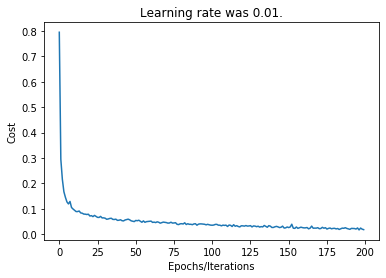

The model achieved a training accuracy of 99.6027%.

The model achieved a testing accuracy of 97.0086%.

The model was able to predict the correct label of the image n°26315, i.e. a [0] digit. See image again below:


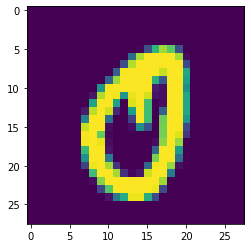

In [21]:
with tf.Session() as session:
    # Initializing
    session.run(init)
    #Instantiating epoch loop
    for epoch in range(hyperparameters["number_epochs"]):
        # Declaring/Updating parameters and/or variables
        batch_cost = 0.
        number_batches = int(number_examples/hyperparameters["minibatch_size"])
        hyperparameters["seed"] += 1
        # Producing random batches
        batches = random_batches(norm_train_images, 
                                 encoded_train_labels, 
                                 hyperparameters["seed"], 
                                 hyperparameters["minibatch_size"])
        # Running forward then backward propagations
        # Updating costs
        for batch in batches:
            (batch_data, batch_labels) = batch
            _, epoch_cost = session.run(fetches = [optimizer, cost], 
                                        feed_dict = {placeholder_data: batch_data, 
                                                     placeholder_labels: batch_labels})
            batch_cost += epoch_cost / number_batches
        # Printing session data if requested
        if (hyperparameters["cost_printing"] == True and epoch % 10 == 0) or \
        epoch == max(range(hyperparameters["number_epochs"])): 
            print(f"Cost after epoch {epoch}: {round(batch_cost, 5)}")
        # Recording batch costs.
        costs.append(batch_cost)
    
    # Plotting costs per iteration
    plt.plot(costs)
    plt.ylabel("Cost")
    plt.xlabel("Epochs/Iterations")
    plt.title(f"Learning rate was {learning_rate}.")
    plt.show()
    
    # Instantiating predictions based on trained model
    predictor = tf.argmax(pass_results, 1)
    correct_prediction = tf.equal(predictor,
                                  tf.argmax(placeholder_labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    # Testing accuracy of model on training data
    for batch in range(int(number_examples/hyperparameters["minibatch_size"])):
        # Establishing a range [start:end] to extract a batch from the training data
        start, end = batch_range(batch, hyperparameters["minibatch_size"], number_examples)
        training_accuracy += accuracy.eval(feed_dict = {placeholder_data: norm_train_images[start:end],
                                                        placeholder_labels: encoded_train_labels[start:end]})
    training_accuracy /= int(number_examples/hyperparameters["minibatch_size"])
    
    # Testing accuracy of model on testing data
    for batch in range(int(norm_test_images.shape[0]/hyperparameters["minibatch_size"])):
        # Establishing a range [start:end] to extract a batch from the training data
        start, end = batch_range(batch, hyperparameters["minibatch_size"], norm_test_images.shape[0])
        testing_accuracy += accuracy.eval(feed_dict = {placeholder_data: norm_test_images[start:end],
                                                       placeholder_labels: encoded_test_labels[start:end]})
    testing_accuracy /= int(norm_test_images.shape[0]/hyperparameters["minibatch_size"])
    
    # Testing accuracy of model on the randomly-picked image in part 2.
    random_image_result = accuracy.eval(feed_dict = {placeholder_data: norm_train_images[random_image].reshape(1,28,28,1), 
                                                     placeholder_labels: encoded_train_labels[random_image].reshape(1,10)})
    
    print(f"The model achieved a training accuracy of {round(training_accuracy, 6)*100}%.\n")
    print(f"The model achieved a testing accuracy of {round(testing_accuracy, 6)*100}%.\n")
    if random_image_result == 1:
        print(f"The model was able to predict the correct label of the image n°{random_image}, " + 
              f"i.e. a {train_labels[random_image]} digit. See image again below:")
    else:
        print(f"The model was not able to predict the correct label of the image n°{random_image}, " + 
              f"i.e. a {int(train_labels[random_image])} digit. See image again below:")
    plt.imshow(norm_train_images[random_image].reshape(28,28))

## 6. Implementing LeNet

In [22]:
status = "WIP"